# TensorFlow Notebook
## Regression

### Linear Regression
This section is created based on the following documentation: https://www.tensorflow.org/tutorials/estimator/linear

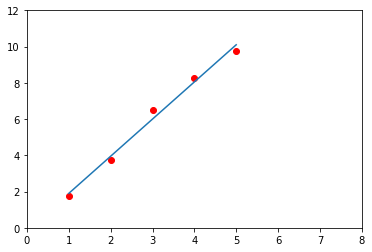

In [2]:
## LIBRARIES
import numpy as np
import matplotlib.pyplot as plt

## DATA
input = [1, 2, 3, 4, 5]
output = [1.75, 3.75, 6.5, 8.25, 9.75]

## VISUALIZING DATA
plt.plot(input, output, "ro") #"ro":Red-o points
plt.axis([0,8,0,12])

## CREATING REGRESSION LINE
inputs = np.unique(input)
model_lr = np.poly1d(np.polyfit(input, output, 1)) #1 is for the 1st degree polynomial
predictions = (model_lr)(inputs)

## VISUALIZING THE REGRESSION LINE
plt.plot(inputs, predictions)
plt.show()

### Libraries

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np              #for multi-dimensional array operations
import pandas as pd             #for data manipulation
import matplotlib.pyplot as plt #for data visualizations
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

### Data Wrangling

#### Data Gathering

In [4]:
df_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') #training data
df_eval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') #testing data

#### Data Check

In [5]:
print("Training set dimensions:", df_train.shape)
print("Testing set dimensions:", df_eval.shape)

Training set dimensions: (627, 10)
Testing set dimensions: (264, 10)


In [6]:
df_train.head(n=3)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y


In [7]:
df_eval.head(n=3)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y


In [8]:
df_train.describe()

,survived,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.387560,29.631308,0.545455,0.379585,34.385399
std,0.487582,12.511818,1.151090,0.792999,54.597730
min,0.000000,0.750000,0.000000,0.000000,0.000000
25%,0.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,28.000000,0.000000,0.000000,15.045800
75%,1.000000,35.000000,1.000000,0.000000,31.387500
max,1.000000,80.000000,8.000000,5.000000,512.329200


#### Data Visualization

<AxesSubplot:>

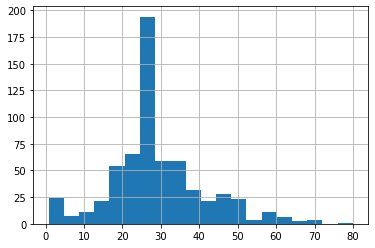

In [9]:
df_train.age.hist(bins=20)

<AxesSubplot:>

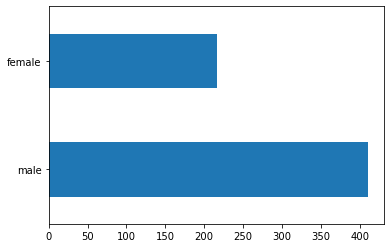

In [10]:
df_train['sex'].value_counts().plot(kind="barh")

<AxesSubplot:>

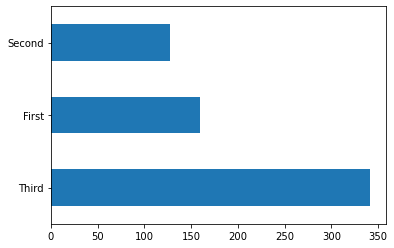

In [11]:
df_train['class'].value_counts().plot(kind="barh")

In [12]:
y_train = df_train.pop('survived') #pop() removes the 'survived' col and assign to the y_train variable
y_eval = df_eval.pop('survived')

In [13]:
pd.concat([df_train, y_train], axis=1)

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone,survived
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n,0
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n,1
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y,1
3,female,35.0,1,0,53.1000,First,C,Southampton,n,1
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y,0
...,...,...,...,...,...,...,...,...,...,...
622,male,28.0,0,0,10.5000,Second,unknown,Southampton,y,0
623,male,25.0,0,0,7.0500,Third,unknown,Southampton,y,0
624,female,19.0,0,0,30.0000,First,B,Southampton,y,1
625,female,28.0,1,2,23.4500,Third,unknown,Southampton,n,0


Text(0.5, 0, '% survive')

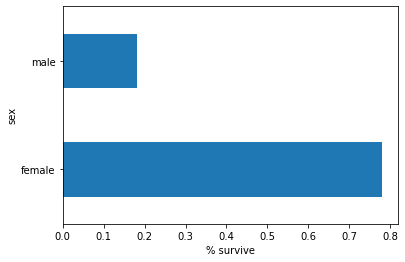

In [14]:
pd.concat([df_train, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

#### Feature Creation

In [15]:
NUMERIC_COLUMNS = ['age', 'fare']
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']

In [16]:
for feature_name in CATEGORICAL_COLUMNS:
    print(feature_name, ":", df_train[feature_name].unique())

sex : ['male' 'female']
n_siblings_spouses : [1 0 3 4 2 5 8]
parch : [0 1 2 5 3 4]
class : ['Third' 'First' 'Second']
deck : ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town : ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone : ['n' 'y']


In [17]:
feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = df_train[feature_name].unique() #getting a list of all unique values from given feature column
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [20]:
for f in feature_columns:
    print(f, "\n")

VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0) 

VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0) 

VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0) 

VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0) 

VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0) 

VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0) 

VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string

#### Creating the Model

In [21]:
## INPUT FUNCTION
'''
The TensorFlow model requires that the data we pass it comes in as a tf.data.Dataset obejct.
This means we must create an input function that can convert our current pandas df into that object
'''

def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function(): 
        
        #creating tf.data.Dataset object with data and its labels
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        
        if shuffle:
            ds = ds.shuffle(1000) #randomizes the order of the data 
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    
    return input_function

In [22]:
train_input_fn = make_input_fn(df_train, y_train)
eval_input_fn  = make_input_fn(df_eval, y_eval, num_epochs=1, shuffle=False) #no need to shuffle for testing set

In [23]:
linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\uuresin\\AppData\\Local\\Temp\\tmp8ojh7vpb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Training the Model

In [25]:
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)
clear_output()
print('Accuracy: ', result['accuracy'])

Accuracy:  0.7689394


In [26]:
result = list(linear_est.predict(eval_input_fn))
idx = 0
print("\nPassenger Information:\n", df_eval.loc[idx])
print("\nPassenger Survival record:", y_eval.loc[idx], "(1 for survived, 0 for deceased)")
print("Survival Prediction (probability):", result[idx]['probabilities'][1])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\uuresin\AppData\Local\Temp\tmp8ojh7vpb\model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Passenger Information:
 sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class          